In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [12]:
# 生成数据点
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

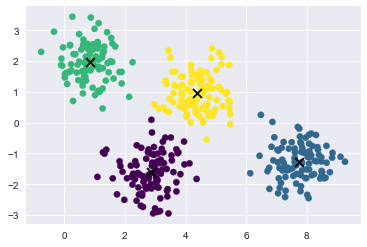

In [15]:
# 绘制出kmeans聚类后的标签的结果
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black', s=80, marker='x')

kmeans算法相当于在每个族的中心放置了一个圆圈，（针对此处的二维数据来说）

半径是根据最远的点与族中心点的距离算出

下面用一个函数将这个聚类圆圈可视化


In [21]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)


    # plot the representation of the KMeans model

    centers = kmeans.cluster_centers_
    ax.scatter(centers[:,0], centers[:, 1], c='black', s=150, marker='x')
    
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    #用列表推导式求出每一个聚类中心 i = 0, 1, 2, 3在自己的所属族的距离的最大值
    #labels == i 返回一个布尔型index，所以X[labels == i]只取出i这个族类的数据点
    #求出这些数据点到聚类中心的距离cdist(X[labels == i], [center])  再求最大值 .max()
    
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

如果数据点不是圆形分布的

kmeans算法的聚类效果就会变差

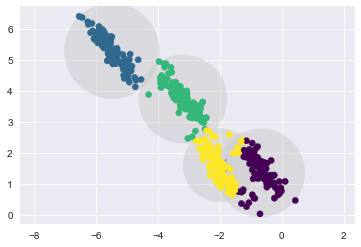

In [23]:
rng = np.random.RandomState(13)
# 这里乘以一个2,2的矩阵，相当于在空间上执行旋转拉伸操作
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### 引出高斯混合模型

高斯混合模型能够计算出每个数据点

属于每个族中心的概率大小

在默认参数设置的、数据简单可分的情况下，

GMM的分类效果与kmeans基本相同

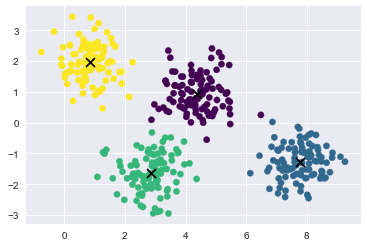

In [34]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');


#gmm的中心点叫做 means_
centers = gmm.means_
plt.scatter(centers[:,0], centers[:, 1], c='black', s=80, marker='x');

得到数据的概率分布结果

In [29]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


编写绘制gmm绘制边界的函数

In [40]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

在圆形数据上的聚类结果

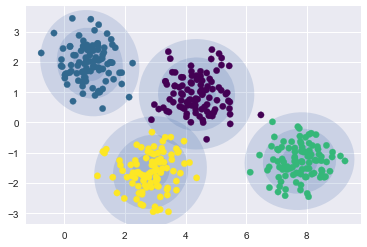

In [41]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

在偏斜拉伸数据上的聚类结果

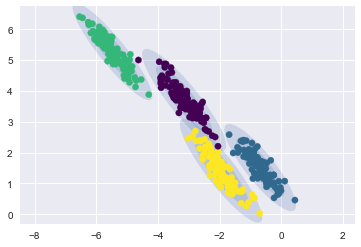

In [42]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## 将GMM用作密度估计

GMM本质上是一个密度估计算法；也就是说，从技术的角度考虑，

一个 GMM 拟合的结果并不是一个聚类模型，而是描述数据分布的生成概率模型。

非线性边界的情况

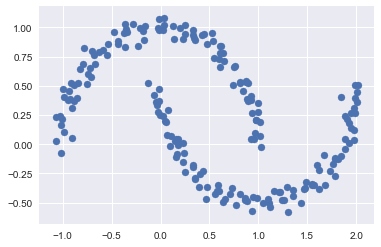

In [47]:
# 构建非线性可分数据

from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

如果使用2个成分聚类（即废了结果设置为2），基本没什么效果

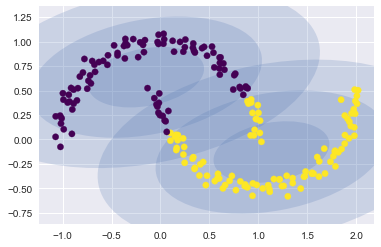

In [48]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

如果设置为多个聚类成分

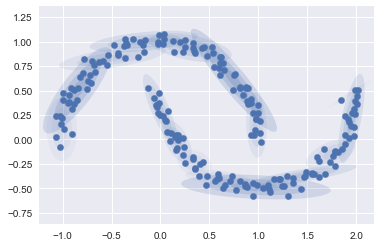

In [49]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

这里采用 16 个高斯曲线的混合形式不是为了找到数据的分隔的簇，而是为了对输入数据的总体分布建模。

## 利用分布函数的生成模型

生成新的，与输入数据类似的随机分布桉树（用于新的数据点）

**用 GMM 拟合原始数据获得的 16 个成分生成的 400 个新数据点**

In [52]:
Xnew = gmm16.sample(400)

In [57]:
Xnew?

In [61]:
Xnew[0][:5]

array([[-0.91802434,  0.4264853 ],
       [-0.79114795,  0.70198326],
       [-1.02085389,  0.22850745],
       [-0.8498637 ,  0.46316015],
       [-0.75870888,  0.67907014]])

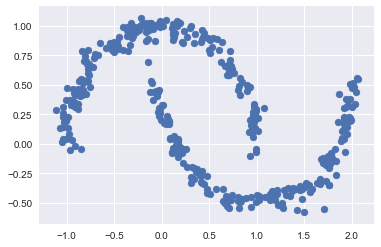

In [62]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

### 需要多少成分？

作为一种生成模型，GMM 提供了一种确定数据集最优成分数量的方法。

- 赤池信息量准则（Akaike information criterion)  [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

- 贝叶斯信息准则（Bayesian information criterion) [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

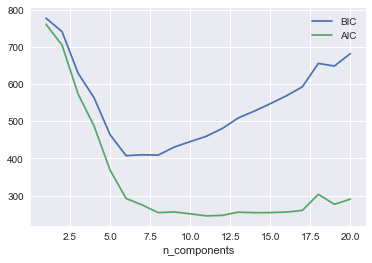

In [64]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

观察可得，在 8~12 个主成分的时候，AIC 较小

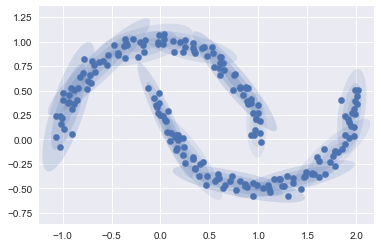

In [65]:
gmm12 = GaussianMixture(n_components=12, covariance_type='full', random_state=0)
plot_gmm(gmm12, Xmoon, label=False)